In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.feature_selection import SelectKBest,f_regression,VarianceThreshold,f_classif,SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score,accuracy_score

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,StackingRegressor,RandomForestClassifier
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.svm import NuSVR,SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import TransformedTargetRegressor


In [2]:
team_feats = pd.read_csv("../.data/team_feats.csv")
games = pd.read_csv("../.data/games.csv")

In [3]:
games=games[games['season']>=2017].copy()

In [4]:
team_feats = pd.DataFrame(np.where(team_feats==0,np.nan,team_feats),
                    columns=team_feats.columns,
                    index=team_feats.index)

In [5]:
home_feats = team_feats.copy()
home_feats.columns = ['home_'+i for i in home_feats.columns]
home_feats.rename(mapper={'home_season':'season'},axis=1,inplace=True)

away_feats = team_feats.copy()
away_feats.columns = ['away_'+i for i in away_feats.columns]
away_feats.rename(mapper={'away_season':'season'},axis=1,inplace=True)

In [78]:
merge = games.merge(home_feats,on=['season','home_team'],how='left').merge(away_feats,on=['season','away_team'],how='left')

for col in [
        i for i in home_feats.columns if i not in ('season','home_team')
    ]:
    other_col = col.replace('home_','away_')
    new_col = col.replace('home_','diff_')
    merge[new_col] = merge[col] - merge[other_col]

all_feats = [
    i for i in home_feats.columns if i not in ('season','home_team')
] + [
    i for i in away_feats.columns if i not in ('season','away_team')
] + [
    i for i in merge.columns if 'diff_' in i
] + ['flg']
target = 'outcome' 
target1 = 'result'

merge['outcome'] = merge['result'] - merge['spread_line']

merge['outcome_hm_beat'] = np.where(merge['outcome']>0,1,0)

merge=merge.copy()
merge['flg'] = 1

merge[all_feats] = merge[all_feats].fillna(0)

val_seasons = ( 2023,2024,2025)
train_seasons = [i for i in merge['season'].unique() if i not in val_seasons]


train = merge[merge['season'].isin(train_seasons)].copy()
val = merge[(merge['season'].isin(val_seasons))&(merge['season']!=2025)].copy()

meandiff = abs(train[train[target]<0][all_feats].mean()/
 train[train[target]>0][all_feats].mean() )
f1 = list(meandiff.sort_values().tail(20).index)
f2 = list(meandiff.sort_values().head(0).index)

scaler = StandardScaler().fit_transform(train[all_feats])
scaled_train = pd.DataFrame(scaler,columns=all_feats,index=train.index)

meandiff = abs(scaled_train[train[target]<0][all_feats].mean() - 
 scaled_train[train[target]>0][all_feats].mean() )
f3 = list(meandiff.sort_values().tail(20).index)

feats = ['flg']+f3#+f1+f2

C:\Users\Jason\AppData\Local\Temp\ipykernel_28820\1391012200.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merge[all_feats] = merge[all_feats].fillna(0)


In [79]:
f3

['home_racr',
 'home_completions',
 'home_special_teams_tds',
 'home_interceptions',
 'home_sacks',
 'away_passing_yards_after_catch',
 'away_interceptions',
 'away_sack_yards',
 'home_carries',
 'diff_sacks',
 'diff_sack_yards',
 'away_rushing_fumbles',
 'diff_interceptions',
 'away_racr',
 'home_rushing_fumbles_lost',
 'home_rushing_yards',
 'away_receiving_fumbles',
 'home_receiving_fumbles_lost',
 'away_special_teams_tds',
 'away_passing_2pt_conversions']

In [80]:
meandiff.sort_values().tail(30)

away_sacks                        0.044918
away_receiving_fumbles_lost       0.044921
away_receiving_air_yards          0.045099
diff_rushing_fumbles              0.045599
diff_rushing_tds                  0.045961
away_rushing_yards                0.046162
home_rushing_2pt_conversions      0.046910
away_rushing_tds                  0.047179
away_rushing_fumbles_lost         0.049991
home_passing_yards                0.050371
home_racr                         0.053226
home_completions                  0.053464
home_special_teams_tds            0.056480
home_interceptions                0.057015
home_sacks                        0.058978
away_passing_yards_after_catch    0.060512
away_interceptions                0.060626
away_sack_yards                   0.067015
home_carries                      0.073951
diff_sacks                        0.074643
diff_sack_yards                   0.074679
away_rushing_fumbles              0.079839
diff_interceptions                0.084698
away_racr  

In [81]:
merge[['spread_line','result','outcome','outcome_hm_beat']]

,spread_line,result,outcome,outcome_hm_beat
0,8.0,-15.0,-23.0,0
1,7.0,9.0,2.0,1
2,-6.5,-6.0,0.5,1
3,2.5,-20.0,-22.5,0
4,-10.0,-3.0,7.0,1
...,...,...,...,...
2476,-1.5,NaN,NaN,0
2477,4.5,NaN,NaN,0
2478,-4.5,NaN,NaN,0
2479,4.5,NaN,NaN,0


In [82]:
target

'outcome'

In [83]:
Xtrain = train[feats].copy()
ytrain = train[target].copy()
Xval = val[feats].copy()
yval = val[target].copy()

In [84]:
corrs = train[all_feats+[target]].corr()[target].sort_values()

corrs[(abs(corrs)>.03)&(abs(corrs)<1)]

home_rushing_fumbles_lost      -0.065918
away_special_teams_tds         -0.056015
diff_passing_air_yards         -0.043850
diff_attempts                  -0.041670
diff_completions               -0.040821
away_sacks                     -0.040036
diff_rushing_fumbles           -0.039239
diff_interceptions             -0.037258
home_receiving_fumbles_lost    -0.035825
diff_passing_yards             -0.034645
diff_receiving_air_yards       -0.034197
home_passing_2pt_conversions   -0.032309
home_attempts                  -0.031752
diff_passing_first_downs       -0.031314
away_sack_yards                -0.030746
away_rushing_fumbles_lost      -0.030012
away_completions                0.030555
away_passing_first_downs        0.031002
diff_sacks                      0.031885
away_passing_air_yards          0.032274
home_rushing_yards              0.033044
away_rushing_fumbles            0.033616
away_receiving_air_yards        0.033741
home_carries                    0.034743
away_interceptio

In [85]:
r1 = RandomForestRegressor(
    random_state=42,
    n_estimators=250,
    #min_samples_leaf=5
    max_features=.63,
    max_samples=.63,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1
)
r1 = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    max_depth=6,
    colsample_bytree=.63,
    subsample=.63,
    n_estimators=250,
    learning_rate=.1,
    reg_alpha=1,
    reg_lambda=1,
    gamma=0,
)
#r1 = LinearRegression(fit_intercept=False)
#r1 = Lasso(fit_intercept=False,alpha=10)
#r1 = ElasticNet(fit_intercept=False,alpha=10)
#r1 = Ridge(fit_intercept=False,alpha=10)


model = Pipeline(
    steps=[
        #('poly',PolynomialFeatures(degree = (1,2))),
        #('thresh',VarianceThreshold(0)),
        #('scaler',StandardScaler()),
        #('selector',SelectKBest(score_func=f_classif,k=25)),
        #('selector',SequentialFeatureSelector(r35,n_features_to_select=20,n_jobs=-1)),
        ('learner',r1)
    ]
)

In [86]:
model.fit(Xtrain,ytrain)

,steps,"[('learner', ...)]"
,transform_input,None
,memory,None
,verbose,False
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.63


In [87]:
yfit = pd.Series(model.predict(Xtrain),index=Xtrain.index)
ypred = pd.Series(model.predict(Xval),index=Xval.index)

In [88]:
def r2_score_mod(ytrue,ypred,ytrain):

    return 1-sum((ytrue - ypred)**2)/sum((ytrue - ytrain.mean())**2)

In [89]:
r2_score_mod(yval,ypred,ytrain)

-0.12185828930211806

In [90]:
r2_score_mod(ytrain,yfit,ytrain)

0.9414676081317194

In [91]:
results = pd.DataFrame(np.where((yval>0)&(ypred>0),'tp',
    np.where((yval<0)&(ypred<0),'tn',
    np.where((yval<0)&(ypred>0),'fp',
    np.where((yval>0)&(ypred<0),'fn','other'
         )))),columns=['res'])
results['cnt'] = 1
print(results.groupby(['res'])['cnt'].count())#/sum(results[results['res']!='other']['cnt']))
print(results.groupby(['res'])['cnt'].count()[['tn','tp']].sum() - results.groupby(['res'])['cnt'].count()[['fn','fp']].sum() )
print(results.groupby(['res'])['cnt'].count()[['fp','tp']].sum() - results.groupby(['res'])['cnt'].count()[['fn','tn']].sum() )

res
fn       131
fp       127
other     18
tn       144
tp       150
Name: cnt, dtype: int64
36
2


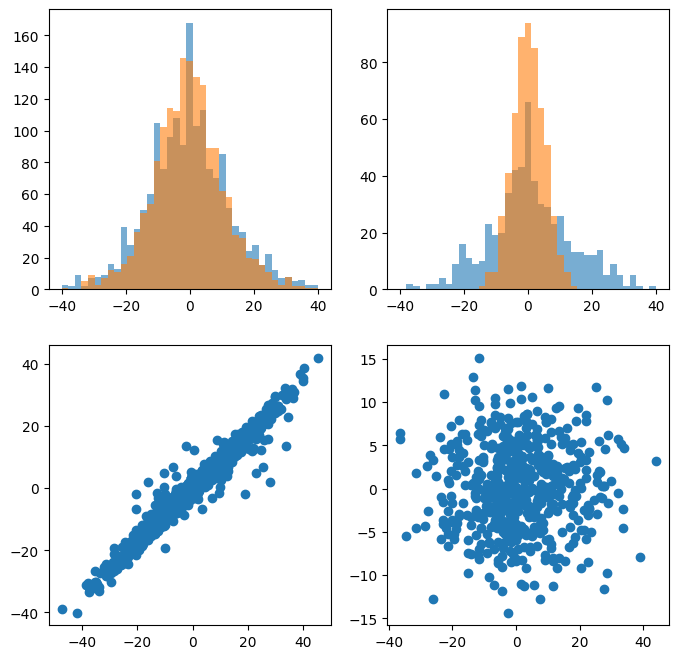

In [92]:
fig,axs = plt.subplots(2,2,figsize=(8,8))

axs[0,0].hist(ytrain,bins=np.linspace(-40,40,40),alpha=.6)
axs[0,0].hist(yfit,bins=np.linspace(-40,40,40),alpha=.6)
axs[0,1].hist(yval,bins=np.linspace(-40,40,40),alpha=.6)
axs[0,1].hist(ypred,bins=np.linspace(-40,40,40),alpha=.6)

axs[1,0].scatter(ytrain,yfit)

axs[1,1].scatter(yval,ypred)
plt.show()


In [93]:

print(results.groupby(['res'])['cnt'].count())#/sum(results[results['res']!='other']['cnt']))
print(results.groupby(['res'])['cnt'].count()[['tn','tp']].sum() - results.groupby(['res'])['cnt'].count()[['fn','fp']].sum() )
print(results.groupby(['res'])['cnt'].count()[['fp','tp']].sum() - results.groupby(['res'])['cnt'].count()[['fn','tn']].sum() )

res
fn       131
fp       127
other     18
tn       144
tp       150
Name: cnt, dtype: int64
36
2


In [94]:
test = merge[merge['season']==2025].copy()
Xtest = test[feats].copy()

predictions = pd.Series(model.predict(Xtest),index=Xtest.index)

In [95]:
test['PREDICTIONS'] = predictions

In [98]:
report = test[test['week']==2][
    ['away_team','home_team','spread_line','PREDICTIONS']
].copy()

report['tm'] = np.where(report['PREDICTIONS']<0,report['away_team'],report['home_team'])
report

,away_team,home_team,spread_line,PREDICTIONS,tm
2225,WAS,GB,3.0,5.823626,GB
2226,CLE,BAL,12.5,1.166931,BAL
2227,JAX,CIN,5.5,-2.254920,JAX
2228,NYG,DAL,3.0,3.232232,DAL
2229,CHI,DET,4.5,1.946978,DET
2230,NE,MIA,2.5,-6.235640,NE
2231,SF,NO,-7.0,-3.623367,SF
2232,BUF,NYJ,-8.5,6.585755,NYJ
2233,SEA,PIT,2.5,-1.368149,SEA
2234,LA,TEN,-5.5,-2.450333,LA


In [97]:
val[val['week']==1][
    ['away_team','home_team','spread_line','home_score','away_score','result','outcome']
]

,away_team,home_team,spread_line,home_score,away_score,result,outcome
1639,DET,KC,4.0,20.0,21.0,-1.0,-5.0
1640,CAR,ATL,3.5,24.0,10.0,14.0,10.5
1641,HOU,BAL,9.5,25.0,9.0,16.0,6.5
1642,CIN,CLE,-1.0,24.0,3.0,21.0,22.0
1643,JAX,IND,-4.0,21.0,31.0,-10.0,-6.0
1644,TB,MIN,4.0,17.0,20.0,-3.0,-7.0
1645,TEN,NO,3.0,16.0,15.0,1.0,-2.0
1646,SF,PIT,-1.5,7.0,30.0,-23.0,-21.5
1647,ARI,WAS,7.0,20.0,16.0,4.0,-3.0
1648,GB,CHI,1.0,20.0,38.0,-18.0,-19.0


In [ ]:
feats